### 4. Support Vector Machine

In [1]:
import pandas as pd
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('df_next.csv')
data = data.drop(columns="Unnamed: 0")
data.head(-20)

,0,1,2,3,4,5,6,7,8,9,10,11
0,7.0,21.0,30.0,2.0,3.0,30.0,2.0,3.0,59.0,7.0,2.0,0.0000
1,7.0,32.0,70.0,2.0,4.0,68.0,2.0,4.0,134.0,7.0,2.0,0.0000
2,7.0,15.0,1.0,2.0,2.0,0.0,2.0,2.0,0.0,7.0,2.0,0.0000
3,7.0,33.0,77.0,2.0,7.0,73.0,2.0,7.0,144.0,7.0,2.0,0.0000
4,7.0,55.0,78.0,3.0,7.0,74.0,3.0,7.0,146.0,8.0,2.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
357916,7.0,32.0,70.0,2.0,4.0,69.0,3.0,4.0,138.0,5.0,1.0,1.0000
357917,7.0,17.0,11.0,2.0,10.0,12.0,4.0,10.0,25.0,9.0,1.0,20.1772
357918,7.0,2.0,75.0,0.0,7.0,72.0,0.0,7.0,142.0,2.0,1.0,10.0000
357919,7.0,26.0,49.0,2.0,16.0,49.0,4.0,16.0,98.0,9.0,1.0,20.0950


In [4]:
y = data.iloc[:,0].values
y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7])
n_classes = y.shape[1]

X = data.iloc[:,1:].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
print("Shape_train:", X_train.shape, "\n"
      "Shape_test: ", X_test.shape, "\n"
      "Shape_y:    ", y.shape)

Shape_train: (239820, 11) 
Shape_test:  (118121, 11) 
Shape_y:     (357941, 8)


In [5]:
scaler = StandardScaler()
clf = OneVsRestClassifier(LinearSVC())

steps = [('normalizer', scaler),('classifier', clf)]
pipe_svc_ = Pipeline(steps)

In [6]:
pipe_svc = pipe_svc_.fit(X_train, y_train)

y_pred_train = pipe_svc.predict(X_train)
y_pred_test = pipe_svc.predict(X_test)
y_score_svc = pipe_svc.decision_function(X_test)

##### Plot all ROC curves and Confusion matrix multiclass(SVM)

In [7]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, accuracy_score
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sn
import itertools

In [8]:
fpr_ = dict()
tpr_ = dict()
roc_auc_ = dict()
for i in range(n_classes):
    fpr_[i], tpr_[i], _ = roc_curve(y_test[:, i], y_score_svc[:, i])
    roc_auc_[i] = auc(fpr_[i], tpr_[i])

# Compute micro-average ROC curve and ROC area
fpr_["micro"], tpr_["micro"], _ = roc_curve(y_test.ravel(), y_score_svc.ravel())
roc_auc_["micro"] = auc(fpr_["micro"], tpr_["micro"])

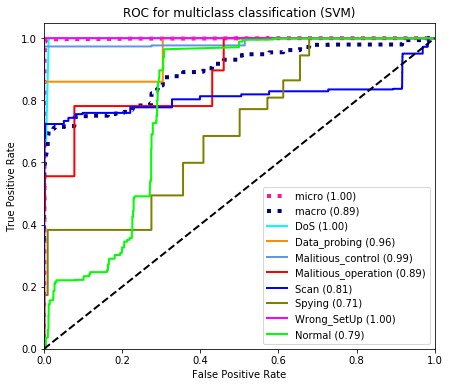

In [9]:
all_fpr = np.unique(np.concatenate([fpr_[i] for i in range(n_classes)]))
lw = 2

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr_[i], tpr_[i])

mean_tpr /= n_classes

fpr_["macro"] = all_fpr
tpr_["macro"] = mean_tpr
roc_auc_["macro"] = auc(fpr_["macro"], tpr_["macro"])

# Plot all ROC curves
classes = ['DoS', 'Data_probing', 'Malitious_control', 'Malitious_operation', 'Scan',
                'Spying', 'Wrong_SetUp', 'Normal']
plt.figure(figsize=(7,6))

plt.plot(fpr_["micro"], tpr_["micro"],
         label='micro ({0:0.2f})'
               ''.format(roc_auc_["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr_["macro"], tpr_["macro"],
         label='macro ({0:0.2f})'
               ''.format(roc_auc_["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'olive', 'fuchsia', 'lime'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_[i], tpr_[i], color=color, lw=lw,
             label='{0} ({1:0.2f})'
             ''.format(classes[i], roc_auc_[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multiclass classification (SVM)')
plt.legend(loc="lower right")
plt.show()

In [10]:
target_names = ['DoS', 'Data_probing', 'Malitious_control', 'Malitious_operation', 'Scan',
                'Spying', 'Wrong_SetUp', 'Normal']
print(classification_report(y_train, y_pred_train, target_names=target_names))
print(classification_report(y_test, y_pred_test, target_names=target_names))
print("accuracy_score(train&test): ",accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))

                     precision    recall  f1-score   support

                DoS       0.96      0.65      0.77      3861
       Data_probing       1.00      0.57      0.72       235
  Malitious_control       0.95      0.93      0.94       589
Malitious_operation       1.00      0.50      0.67       535
               Scan       1.00      0.16      0.27      1044
             Spying       0.00      0.00      0.00       370
        Wrong_SetUp       1.00      1.00      1.00        82
             Normal       0.98      1.00      0.99    233104

          micro avg       0.98      0.99      0.98    239820
          macro avg       0.86      0.60      0.67    239820
       weighted avg       0.98      0.99      0.98    239820
        samples avg       0.98      0.99      0.98    239820

                     precision    recall  f1-score   support

                DoS       0.97      0.67      0.79      1919
       Data_probing       1.00      0.63      0.77       107
  Malitious_control 

In [12]:
confusion_m = confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1))

def confusion_matrix(confusion_m, classes,
                          normalize=False,
                          title=' ',
                          cmap=plt.cm.BuPu):

    if normalize:
        confusion_m = confusion_m.astype('float') / confusion_m.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix (Normalized)")
    else:
        print('Confusion matrix (without_normalization)')

    print(confusion_m)

    plt.imshow(confusion_m, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(orientation='horizontal', shrink=0.5, extend='max', extendfrac=0.1, extendrect=False, drawedges=False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = confusion_m.max() / 2.
    for i, j in itertools.product(range(confusion_m.shape[0]), range(confusion_m.shape[1])):
        plt.text(j, i, format(confusion_m[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_m[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix (without_normalization)
[[  1286      0      0      0      0      0      0    633]
 [     0     67      0      0      0      0      0     40]
 [     0      0    275      0      0      0      0     25]
 [     0      0      0    120      0      0      0    150]
 [     3      0      9      0     77      0      0    414]
 [     0      0      0      0      0      0      0    162]
 [     0      0      0      0      0      0     40      0]
 [   130      0      0      0      0      0      0 114690]]


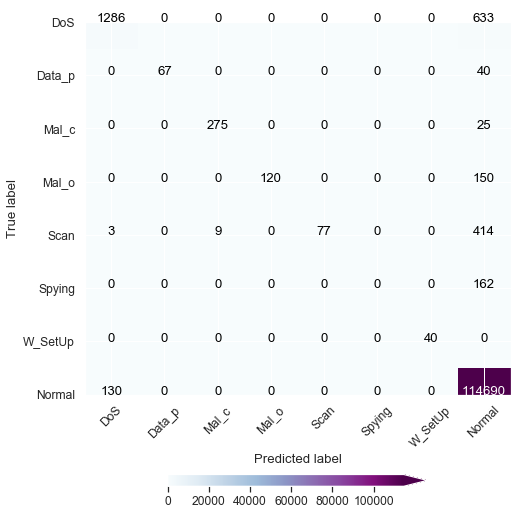

In [13]:
plt.figure(figsize = (8,8))
sn.set(font_scale=1.1)

confusion_matrix(confusion_m,['DoS', 'Data_p', 'Mal_c', 'Mal_o', 'Scan',
                'Spying', 'W_SetUp', 'Normal'])
plt.show()